In [184]:
%load_ext autoreload

%autoreload 2
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/PySSC/')
import PySSC
import corner
import numpy as np
import matplotlib.pyplot as plt
import scipy
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
import analysis_mcmc_cosmo_samples as analysis
import pyccl as ccl
import h5py, glob
from astropy.table import Table
import emcee
import _planck_erosita_spt_samples as _samples

sys.path.append('../modules/')
import covariance as covar
import utils
import pandas as pd
import abundance as cl_count
import unbinned_model_hybrid as ub

#import unbinned module
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/notebooks/Unbinned_likelihood_with_SSC/mcmc_modules/')
import standard_unbinned_likelihood
import PINOCCHIO_cat
import pickle

def save_pickle(dat, filename, **kwargs):
    pickle.dump(dat, open(filename, "wb"))  
    
    

#true cosmology
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

#define cosmology
cosmo = ccl.Cosmology(Omega_c = Omegam_true - Omega_b_true, Omega_b = Omega_b_true, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

mass_in = ccl.halos.massdef.MassDef('vir', 'matter')
mass_out = ccl.halos.massdef.MassDef('500', 'critical')
concentration = conc = ccl.halos.concentration.ConcentrationDuffy08(mass_def=mass_in)
mass_translator = ccl.halos.massdef.mass_translator(mass_in=mass_in,
                                                   mass_out=mass_out, 
                                                   concentration=concentration)

code, index_analysis = '1', 6

sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/notebooks/Unbinned_likelihood_with_SSC/mcmc_modules/')

likelihood = analysis.analysis_unbinned['likelihood'][int(index_analysis)]
analysis_name = analysis.analysis_unbinned['analysis_name'][int(index_analysis)]
    
mapping = ub.Mapping()
mapping.set_cosmology(cosmo)

#load data
fsky = analysis.fsky[analysis.analysis_name.index(analysis_name)]
n_cat = analysis.n_cat[analysis.analysis_name.index(analysis_name)]
reshape_sky = analysis.reshape_sky[analysis.analysis_name.index(analysis_name)]
mapping0 = ub.Mapping()
mapping0.set_cosmology(cosmo)

print(f'LIKELIHOOD = {likelihood}')
print(f'SAMPLE = {analysis_name}')
print(f'f_SKY = {fsky*100} %')

print('===> loading catalog')
where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
cat = glob.glob(where_cat)
ra, dec, redshift, Mvir = _samples.concatenate(n_cat, cat)
cat_ = Table()
cat_['ra'] = ra
cat_['dec'] = dec
cat_['z'] = redshift
cat_['M'] = Mvir
print('===> sky mask reshaping')
ra_, dec_, redshift_, Mvir_ = _samples.mask_fsky(fsky, cat_, reshape=reshape_sky)
M500c_ = np.array([mass_translator(cosmo, Mvir_[i], 1/(1+redshift_[i])) for i in range(len(Mvir_))])
if analysis_name=='spt':
     mask_ = _samples.spt(redshift_, M500c_, Mvir_)
elif analysis_name=='erosita':
    mask_ = _samples.erosita(redshift_, M500c_, Mvir_)
elif analysis_name=='planck':
    mask_ = _samples.planck(redshift_, M500c_, Mvir_)
elif analysis_name=='pinocchio':
    mask_ = _samples.pinocchio(redshift_, M500c_, Mvir_)
cat_final = Table()
cat_final['ra'] = ra_[mask_]
cat_final['dec'] = dec_[mask_]
cat_final['z'] = redshift_[mask_]
cat_final['M'] = Mvir_[mask_]

z_sample, logm_sample = cat_final['z'], np.log10(cat_final['M'])
print(f'NCL = {len(z_sample):.0f} clusters')
print('===> define hybrid redshift binning')
if analysis_name=='spt': redshift_edges = np.linspace(0.25, 1.5, 5)
elif analysis_name=='erosita': redshift_edges = np.linspace(0.1, 2, 5)
elif analysis_name=='planck': redshift_edges = np.linspace(0.1, 0.8, 5)
elif analysis_name=='pinocchio': redshift_edges = np.linspace(0.1, 2, 5)
    
redshift_intervals = [[redshift_edges[i], redshift_edges[i+1]] for i in range(len(redshift_edges)-1)]
print('===> Compute Sij')
default_cosmo_params = {'omega_b':cosmo['Omega_b']*cosmo['h']**2, 
                            'omega_cdm':cosmo['Omega_c']*cosmo['h']**2, 
                            'H0':cosmo['h']*100, 
                            'n_s':cosmo['n_s'], 
                            'sigma8': cosmo['sigma8'],
                            'output' : 'mPk'}
z_arr = np.linspace(0.1,2.1,1000)
nbins_T   = len(redshift_intervals)
windows_T = np.zeros((nbins_T,len(z_arr)))
for i, z_bin in enumerate(redshift_intervals):
    for k, z in enumerate(z_arr):
        if ((z>z_bin[0]) and (z<=z_bin[1])):
            windows_T[i,k] = 1  
Sij_fullsky = PySSC.Sij_alt_fullsky(z_arr, windows_T, order=1, cosmo_params=default_cosmo_params, cosmo_Class=None, convention=0)
Sij = Sij_fullsky/fsky

z_grid = np.linspace(0.1, 2.1, 501)
logm_grid = np.linspace(14, 16, 500)
print('===> mask the hmf theory')
def mask_map():
    Z_grid = np.tile(z_grid,(len(logm_grid), 1))
    LogMvir_grid = np.tile(logm_grid,(len(z_grid), 1)).T
    LogM500c_grid = np.zeros(LogMvir_grid.shape)
    for k, z in enumerate(z_grid):
        M500c = np.array([mass_translator(cosmo, 10**LogM, 1/(1+z)) for LogM in logm_grid])
        LogM500c_grid[:,k] = np.log10(M500c)
    if analysis_name=='spt':
        mask = _samples.spt(Z_grid, 10**LogM500c_grid, 10**LogMvir_grid)
    elif analysis_name=='erosita':
        mask = _samples.erosita(Z_grid, 10**LogM500c_grid, 10**LogMvir_grid)
    elif analysis_name=='planck':
        mask = _samples.planck(Z_grid, 10**LogM500c_grid, 10**LogMvir_grid)
    elif analysis_name=='pinocchio':
        mask = _samples.pinocchio(Z_grid, 10**LogM500c_grid, 10**LogMvir_grid)
    return np.where(mask==True, 1, 0)

#computing default amplitude of matter fluctuations
mask_sample = mask_map()
dN_dlogmdz_map = mapping0.compute_dN_dlogMdzdOmega_map(z_grid, logm_grid, fsky) * mask_sample
halo_bias_map = mapping0.compute_halo_bias_map(z_grid, logm_grid) * mask_sample
Nth = mapping.compute_N_th(z_grid, logm_grid, dN_dlogmdz_map)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
LIKELIHOOD = full_unbinned
SAMPLE = erosita
f_SKY = 100 %
===> loading catalog
===> sky mask reshaping
NCL = 185855 clusters
===> define hybrid redshift binning
===> Compute Sij
===> mask the hmf theory


In [191]:
print(f'NTH = {Nth:.1f}')

def SSC_contribution(theta):
    Om, s8 = theta
    cosmo_new = ccl.Cosmology(Omega_c = Om - Omega_b_true, Omega_b = Omega_b_true, 
                              h = 0.6777, sigma8 = s8, n_s=0.96)
    mapping = ub.Mapping()
    mapping.set_cosmology(cosmo_new)
    dN_dlogmdz_map = mapping.compute_dN_dlogMdzdOmega_map(z_grid, logm_grid, fsky) * mask_sample
    Nth = mapping.compute_N_th(z_grid, logm_grid, dN_dlogmdz_map)
    mapping.compute_bdNdm_zbins_and_dNdm_zbins(z_grid, logm_grid, 
                                                   dN_dlogmdz_map, halo_bias_map, 
                                                   redshift_intervals, fsky)
    mapping.compute_Nb_zbins(z_grid, logm_grid, 
                                 dN_dlogmdz_map, halo_bias_map, 
                                 redshift_intervals, fsky)
    mapping.interp(z_grid, logm_grid, dN_dlogmdz_map, halo_bias_map, 
                       redshift_intervals, Sij, fsky)
    dN_dlogM = mapping.N_map_interp_fct(z_sample, logm_sample, redshift_intervals)
    #plt.hist(np.log(dN_dlogM), bins=100)
    print(len(dN_dlogM[dN_dlogM < 0]))
    print(min(np.log(dN_dlogM)))
    print(max(np.log(dN_dlogM)))
    print(np.sum(np.log(dN_dlogM)))
    print(Nth)
    mask = dN_dlogM < 0
    plt.scatter(z_sample, logm_sample,)
    plt.scatter(z_sample[mask], logm_sample[mask], s=10)
    return 0
    
def loglikelihood(theta):
    Om, s8 = theta
    if Om > 1: return -np.inf
    if Om < 0.1: return -np.inf
    if s8 > 1: return -np.inf
    if s8 < 0.2: return -np.inf
    return SSC_contribution(theta)

NTH = 186818.2


In [192]:
12*180000

2160000

0
1.7992102003672303
12.890026609211903
2242091.2576142373
186818.20756183233
0


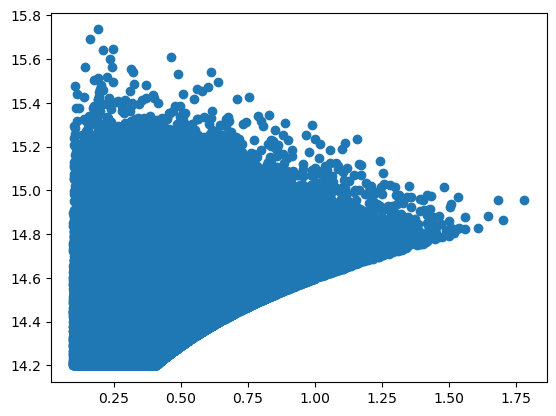

In [193]:
print(loglikelihood([Omega_c_true + Omega_b_true, sigma8_true]))